In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from windrose import WindroseAxes
from windrose import plot_windrose
import matplotlib.cm as cm
from PIL import Image
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
from fbprophet import Prophet
import math
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

#from common.utils import load_data, mape

#pd.options.display.float_format='{:,.2f}'.format
#np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")



df = pd.read_csv('preprocessed_data_15_weeks.csv')
df.ds= pd.to_datetime(df.ds)

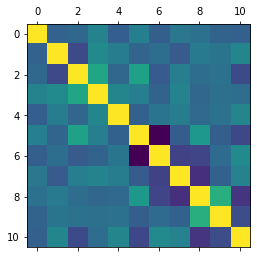

In [2]:
plt.matshow(df.corr())
plt.show()

In [3]:
#a_hum=(6.112*r_hum*math.exp((17.62*temp)/(243.12+temp)))/(461.5*(temp+273.15))
#df['a_hum'] = df.apply(lambda row: (6.112*row['r_hum']*math.exp((17.62*row['temp'])/(243.12+row['temp'])))/(461.5*(row['temp']+273.15)))
a_hum = []
counter = 0
for row in range(len(df['r_hum'])):
    ah=(6.112*df['r_hum'][row]*math.exp((17.62*df['temp'][row])/(243.12+df['temp'][row])))/(461.5*(df['temp'][row]+273.15))
    a_hum.append(ah)
df['a_hum']=a_hum
df.head()
#df=df.set_index('ds')

,ds,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum
0,2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667,0.010100
1,2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000,0.009896
2,2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333,0.009783
3,2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000,0.009689
4,2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667,0.009570


In [4]:
#df = df.drop(['ds', 'dan', 'temp','r_hum','temp_e','r_hum_e'], axis=1)
#df['wind_component'] = df['wind_s'] * np.sin(df['wind_a'])
#df['wind_component'] = df['wind_component'].clip(lower=0)
#df = df.drop(['wind_s', 'wind_a'], axis=1)
##df = df[df.co_2 > 1200]
#df.shape

In [5]:
#df.head()

In [6]:
#df = df[df.co_2 > 1200]

#x = df.values #returns a numpy array
#min_max_scaler = MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#df = pd.DataFrame(x_scaled)
#df.head()
df_hum=df[['ds','a_hum']].copy()
df_hum = df_hum.rename(columns={'a_hum': 'y'})

In [7]:
train = df_hum.copy()
validation = df_hum.copy()
test = df_hum.copy()

train = train[0:1970]
validation = validation[1970:2215]
test = test[2215:]
print(train.shape)
print(validation.shape)
print(test.shape)

(1970, 2)
(245, 2)
(245, 2)


In [8]:
T = 6 #the number of lag variables, previous 6 hours
HORIZON = 1 #predicting next hour


In [9]:
#train = train['y']
train = train.set_index('ds')
#train = train.drop(['floor','cap'], axis=1)
train.head()


validation = validation.set_index('ds')
validation.head()

test = test.set_index('ds')
test.head()



,y
ds,
2021-04-01 19:00:00,0.012102
2021-04-01 20:00:00,0.012104
2021-04-01 21:00:00,0.012018
2021-04-01 22:00:00,0.011972
2021-04-01 23:00:00,0.011970


In [10]:
scaler = MinMaxScaler()
train['y'] = scaler.fit_transform(train)
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['y'].shift(-1, freq='H')

validation['y'] = scaler.fit_transform(validation)
validation_shifted = validation.copy()
validation_shifted['y_t+1'] = validation_shifted['y'].shift(-1, freq='H')

test['y'] = scaler.fit_transform(test)
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['y'].shift(-1, freq='H')

In [11]:
for t in range (1, T+1):
    train_shifted[str(T-t)]=train_shifted['y'].shift(T-t, freq='H')
y_col = 'y_t+1'
x_cols = ['y_t-5', 'y_t-4', 'y_t-3', 'y_t-2', 'y_t-1', 'y_t']
train_shifted.columns = ['y_original'] + [y_col] + x_cols
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

for t in range (1, T+1):
    validation_shifted[str(T-t)]=validation_shifted['y'].shift(T-t, freq='H')
y_col = 'y_t+1'
x_cols = ['y_t-5', 'y_t-4', 'y_t-3', 'y_t-2', 'y_t-1', 'y_t']
validation_shifted.columns = ['y_original'] + [y_col] + x_cols
validation_shifted = validation_shifted.dropna(how='any')
validation_shifted.head(5)

for t in range (1, T+1):
    test_shifted[str(T-t)]=test_shifted['y'].shift(T-t, freq='H')
y_col = 'y_t+1'
x_cols = ['y_t-5', 'y_t-4', 'y_t-3', 'y_t-2', 'y_t-1', 'y_t']
test_shifted.columns = ['y_original'] + [y_col] + x_cols
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)



,y_original,y_t+1,y_t-5,y_t-4,y_t-3,y_t-2,y_t-1,y_t
ds,,,,,,,,
2021-04-02 00:00:00,0.769896,0.766150,0.822337,0.822770,0.798130,0.784707,0.784118,0.769896
2021-04-02 01:00:00,0.766150,0.757585,0.822770,0.798130,0.784707,0.784118,0.769896,0.766150
2021-04-02 02:00:00,0.757585,0.745918,0.798130,0.784707,0.784118,0.769896,0.766150,0.757585
2021-04-02 03:00:00,0.745918,0.731961,0.784707,0.784118,0.769896,0.766150,0.757585,0.745918
2021-04-02 04:00:00,0.731961,0.720432,0.784118,0.769896,0.766150,0.757585,0.745918,0.731961


In [12]:
y_train = train_shifted[y_col].to_numpy()
x_train = train_shifted[x_cols].to_numpy()

y_valid = validation_shifted[y_col].to_numpy()
x_valid = validation_shifted[x_cols].to_numpy()

y_test = test_shifted[y_col].to_numpy()
x_test = test_shifted[x_cols].to_numpy()

In [13]:
x_train = x_train.reshape(x_train.shape[0], T, 1)

x_valid = x_valid.reshape(x_valid.shape[0], T, 1)
x_test = x_test.reshape(x_test.shape[0], T, 1)

In [14]:
y_train.shape

(1862,)

In [15]:
x_train.shape

(1862, 6, 1)

In [16]:
y_valid.shape


(239,)

In [17]:
x_valid.shape

(239, 6, 1)

In [18]:
y_test.shape

(239,)

In [19]:
x_test.shape

(239, 6, 1)

In [20]:
#preprocessing DONE!!
#univariate models page 167

In [21]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [22]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

In [23]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [24]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [25]:
GRU_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [26]:
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid, y_valid), callbacks=[GRU_earlystop], verbose=1)

Epoch 1/10
59/59 [==============================] - 1s 20ms/step - loss: 0.1052 - val_loss: 0.0248
Epoch 2/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0164 - val_loss: 0.0182
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0152
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0109
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0103
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0088
Epoch 8/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 9/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0079
Epoch 10/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0077


In [27]:
ts_predictions = model.predict(x_test)

In [28]:
ts_predictions

array([[0.7246717 ],
       [0.72052217],
       [0.71433043],
       [0.70476043],
       [0.69269913],
       [0.68238056],
       [0.66954815],
       [0.5895749 ],
       [0.7371602 ],
       [0.83875686],
       [0.85259604],
       [0.7862489 ],
       [0.7436497 ],
       [0.7034641 ],
       [0.7061153 ],
       [0.6992947 ],
       [0.67781895],
       [0.65681213],
       [0.76864815],
       [0.7572262 ],
       [0.7490695 ],
       [0.75840205],
       [0.7747493 ],
       [0.7716591 ],
       [0.7566515 ],
       [0.7392348 ],
       [0.72374904],
       [0.70900404],
       [0.6942741 ],
       [0.682619  ],
       [0.66892356],
       [0.6722248 ],
       [0.719054  ],
       [0.7854425 ],
       [0.77722657],
       [0.73813546],
       [0.7433268 ],
       [0.7294193 ],
       [0.7205853 ],
       [0.734016  ],
       [0.6972432 ],
       [0.7876007 ],
       [0.9174633 ],
       [0.88213056],
       [0.8493663 ],
       [0.8354566 ],
       [0.8292682 ],
       [0.779

In [29]:
ev_ts_data = pd.DataFrame(ts_predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
ev_ts_data['timestamp']=test_shifted.index
ev_ts_data=pd.melt(ev_ts_data, id_vars='timestamp', value_name='prediction', var_name='h')
ev_ts_data['actual']=np.transpose(y_test).ravel()
ev_ts_data[['prediction', 'actual']]=scaler.inverse_transform(ev_ts_data[['prediction','actual']])
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2021-04-02 00:00:00,t+1,0.011764,0.011908
1,2021-04-02 01:00:00,t+1,0.011750,0.011878
2,2021-04-02 02:00:00,t+1,0.011729,0.011838
3,2021-04-02 03:00:00,t+1,0.011696,0.011790
4,2021-04-02 04:00:00,t+1,0.011654,0.011750


In [34]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return (((ts_predictions - actuals).abs() / actuals).mean())

mape(ev_ts_data['prediction'], ev_ts_data['actual'])

0.02131319649446812

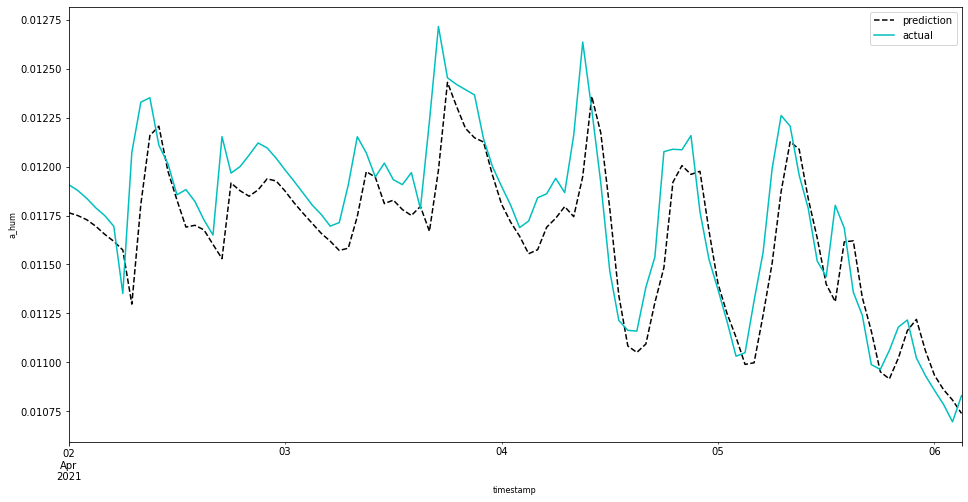

In [41]:
ev_ts_data[0:100].plot(x='timestamp',y=['prediction','actual'], style=['k--','c'], figsize=(16,8))
plt.xlabel('timestamp', fontsize=8)
plt.ylabel('a_hum', fontsize=8)
plt.show()

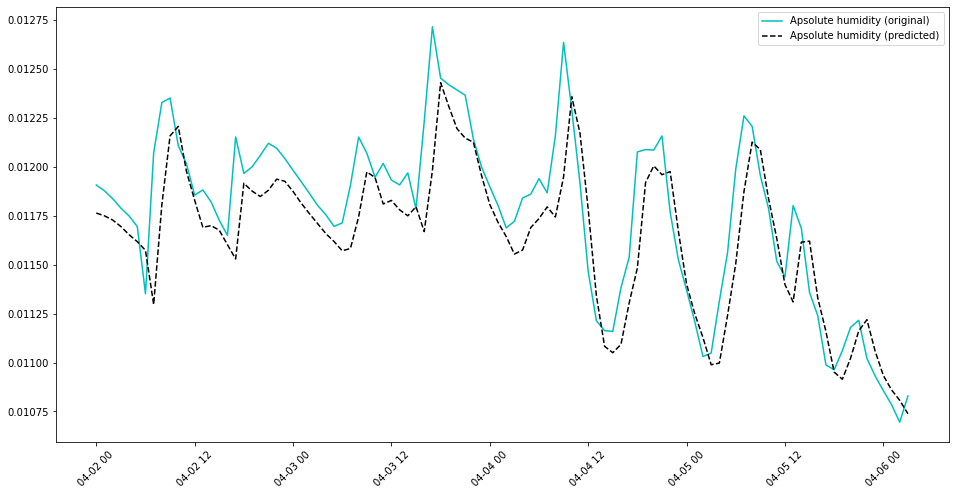

In [42]:
plt.rcParams['figure.figsize']=[16,8]
plt.rcParams.update({'font.size':10})
plt.plot(ev_ts_data['timestamp'][0:100],ev_ts_data['actual'][0:100],color='c',LineWidth=1.5,label='Apsolute humidity (original)')
plt.plot(ev_ts_data['timestamp'][0:100],ev_ts_data['prediction'][0:100],color='k',linestyle ='dashed',LineWidth=1.5,label='Apsolute humidity (predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('page_GRU.pdf',
            dpi=600,
            orientation='landscape')